# PART-I: Building your own GAN (Generative Adversarial Networks) on Amazon SageMaker

## About this part

In this part, you will build, train and test your GAN on Amazon SageMaker. This part allows you to apply the theorical learnings from the presentation.
This part is mostly based on this [AWS Blog Post](https://aws.amazon.com/blogs/machine-learning/build-gan-with-pytorch-and-amazon-sagemaker/).


#### Deep Convolutional GANs - DCGANs: Adding a Convolutional Neural Networks (CNNs) to GAN to make it even better at image generation
Deep Convolutional Generative Adversarial Networks (DCGANs) are a variant of Generative Adversarial Networks (GANs) that incorporating deep convolutional neural networks (CNNs). The primary reason for adding CNNs to GANs is to improve their performance in generating high-quality images. You can see from the below picture that CNNs covers a larger cell which helps to process multiple pixels in image processing. Overall, the incorporation of deep convolutional networks into GANs can significantly improve their performance in generating high-quality, realistic images, making DCGANs a popular choice for image generation tasks in various domains.

<img src = "./resources/Convolution_arithmetic_Padding_strides.gif" width="300" height="180">


As a result, our DC-GAN will have the below architecture of *Generator* and *Discriminator* models.

<img src = "./resources/Architecture-image.png" width="700" height="250">

## LAB-I
You can run this notebook with Data Science 3.0 confiuguration and with ml.m5.large


### 1) Environment setup
Upgrade packages

In [2]:
!pip install --upgrade pip sagemaker awscli boto3 numpy ipywidgets --quiet
!pip install Pillow==7.1.2 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.4 which is incompatible.
notebook 6.5.6 requires jupyter-client<8,>=5.3.4, but you have jupyter-client 8.6.0 which is incompatible.
notebook 6.5.6 requires pyzmq<25,>=17, but you have pyzmq 25.1.2 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.26.4 which is incompatible.
panel 0.13.1 requires bokeh<2.5.0,>=2.4.0, but you have bokeh 3.3.2 which is incompatible.
sagemaker-datawrangler 0.4.3 requires ipywidgets<8.0.0, but you have ipywidgets 8.1.2 which is incompatible.
sagemaker-datawrangler 0.4.3 requires sagemaker-dat

Create folders

In [3]:
!mkdir -p data src tmp

In [4]:
!pip install torch torchvision

  Using cached torch-2.2.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchvision-0.17.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached typing_extensions-4.10.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Usin

### 2) Download data
There are many public datasets on the Internet, which are very helpful for machine learning engineering and scientific research, such as algorithm study and evaluation. We will use MNIST dataset, which is a handwritten digits dataset, we will use it to train a GAN model, and eventually generate some fake "handwritten" digits.

In [5]:
import boto3
from sagemaker.s3 import S3Downloader as s3down

s3down.download(
    f"s3://sagemaker-example-files-prod-{boto3.session.Session().region_name}/datasets/image/MNIST/pytorch/",
    "./data",
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


['./data/MNIST/processed/test.pt',
 './data/MNIST/processed/training.pt',
 './data/MNIST/raw/t10k-images-idx3-ubyte',
 './data/MNIST/raw/t10k-images-idx3-ubyte.gz',
 './data/MNIST/raw/t10k-labels-idx1-ubyte',
 './data/MNIST/raw/t10k-labels-idx1-ubyte.gz',
 './data/MNIST/raw/train-images-idx3-ubyte',
 './data/MNIST/raw/train-images-idx3-ubyte.gz',
 './data/MNIST/raw/train-labels-idx1-ubyte',
 './data/MNIST/raw/train-labels-idx1-ubyte.gz']

### 3) Data preparation and investigation

PyTorch framework has a torchvision.datasets package, which provides access to a number of datasets, you may use the following commands to read MNIST pre-downloaded dataset from local storage, for later use.


#### a) Data Preparation and examples

DATASET DETAILS:

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

HERE ARE SOME EXAMPLES FROM THE TRAINING DATASET:



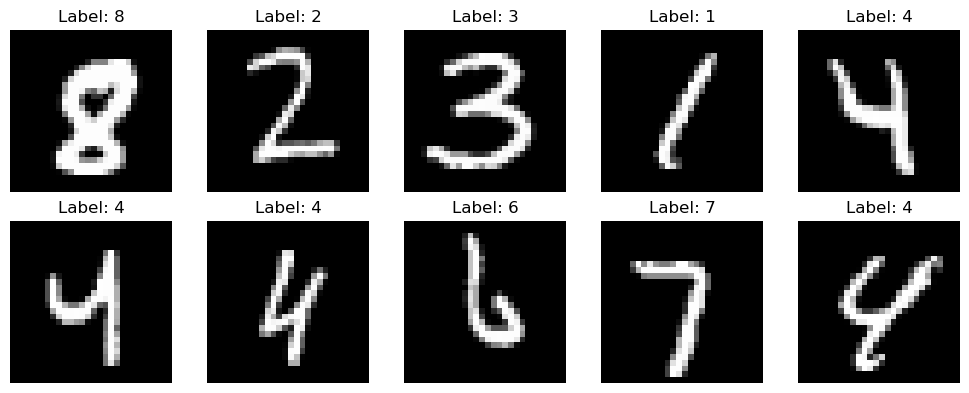

In [6]:
from torchvision import datasets
import torch
import torchvision
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Showing dataset details
dataroot = "./data"
trainset = datasets.MNIST(root=dataroot, train=True, download=False)
testset = datasets.MNIST(root=dataroot, train=False, download=False)
print("DATASET DETAILS:\n")
print(trainset)
print(testset)


# Showing some examples
# Extract the images and labels from the dataset
images, labels = trainset.data, trainset.targets

# Convert the images and labels to PyTorch tensors
images = torch.stack([torch.tensor(image).clone().detach() for image in images])
labels = torch.tensor(labels).clone().detach()

# Normalize the pixel values to be between 0 and 1
images = images.float() / 255.0

# Select 10 random images from the dataset
indices = torch.randperm(len(images))[:10]
selected_images = images[indices]
selected_labels = labels[indices]

# Plot the selected images
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()

for i, (image, label) in enumerate(zip(selected_images, selected_labels)):
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].set_title(f'Label: {label.item()}')
    axs[i].axis('off')

print("\nHERE ARE SOME EXAMPLES FROM THE TRAINING DATASET:\n")
plt.tight_layout()
plt.show()

#### b) Uploading the data to S3 bucket for training job
SageMaker SDK will create a default Amazon S3 bucket for you to access various files and data, that you may need in the machine learning engineering lifecycle. We can get the name of this bucket through the default_bucket method of the sagemaker.session.Session class in the SageMaker SDK.

In [7]:
from sagemaker.session import Session
import os
from sagemaker.s3 import S3Uploader as s3up

sess = Session()

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket here if you wish.
bucket = sess.default_bucket()
prefix = "byos-pytorch-gan"

# Location to save your custom code in tar.gz format.
s3_custom_code_upload_location = f"s3://{bucket}/{prefix}/customcode"

# Location where results of model training are saved.
s3_model_artifacts_location = f"s3://{bucket}/{prefix}/artifacts/"

s3_data_location = s3up.upload(
    os.path.join(dataroot, "MNIST"), f"s3://{bucket}/{prefix}/data/mnist"
)

### 4) Model Building




#### a) Let's build the`Generator` model and write it to our train.py file

**Generator**:
The generator architecture consists of a series of convolutional transpose layers (also known as deconvolution or fractionally-strided convolution), batch normalization layers, and ReLU activation functions. The input to the generator is a noise vector of size `nz`, and the output is an image of size `nc` x 64 x 64, where `nc` represents the number of channels (e.g., 3 for RGB images).

Here's a breakdown of the architecture:

1. **Input**: The input is a noise vector of size `nz`.

2. **Convolutional Transpose Layer**: The first layer is a convolutional transpose layer that takes the noise vector and transforms it into a 4x4 feature map with `ngf*8` channels. The `ngf` parameter represents the number of generator features, which is a hyperparameter that determines the complexity of the generator.

3. **Batch Normalization and ReLU**: After the convolutional transpose layer, a batch normalization layer and a ReLU activation function are applied.

4. **Upsampling Blocks**: The next few layers are upsampling blocks that gradually increase the spatial resolution of the feature maps while decreasing the number of channels. Each upsampling block consists of:
   - A convolutional transpose layer with a stride of 2 for upsampling
   - A batch normalization layer
   - A ReLU activation function

5. **Output Layer**: The final layer is a convolutional transpose layer that produces the output image with `nc` channels and a size of 64x64 pixels. The `Tanh` activation function is applied to the output, which scales the pixel values between -1 and 1, as is common for image generation tasks.


#### Meanwhile, we will be greating train.py file which will be used for packaging the training at the training stage.

In [8]:
%%writefile src/train.py

from __future__ import print_function
import argparse
import json
import logging
import os
import sys
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F

import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils


cudnn.benchmark = True

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


class Generator(nn.Module):
    def __init__(self, *, nz, nc, ngf, ngpu=1):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

    def save(self, path, *, filename=None, device="cpu"):
        # recommended way from http://pytorch.org/docs/master/notes/serialization.html
        self.to(device)
        if not filename is None:
            path = os.path.join(path, filename)
        torch.save(self.state_dict(), path)

    def load(self, path, *, filename=None):
        if not filename is None:
            path = os.path.join(path, filename)
        with open(path, "rb") as f:
            self.load_state_dict(torch.load(f))

Overwriting src/train.py


#### b) Building the`Discriminator` model and write it to our train.py file

**Dsicriminator**:
The provided code defines a Discriminator class for our DC-GAN using PyTorch. The Discriminator is a convolutional neural network (CNN) that takes an input image and determines whether it is real or generated by the Generator network. The architecture consists of the following layers:

1. `nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)`: This is a 2D convolutional layer that takes an input image of size `(nc) x 64 x 64`, where `nc` is the number of input channels (e.g., 3 for RGB images). The layer has `ndf` output channels (feature maps), a kernel size of `4x4`, a stride of `2`, and padding of `1`. The `bias=False` parameter indicates that there are no bias terms in this layer.

2. `nn.LeakyReLU(0.2, inplace=True)`: This is a Leaky ReLU activation function with a negative slope of `0.2`. The `inplace=True` parameter means that the operation is performed in-place, modifying the input tensor to save memory.

3. `nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)`: Another 2D convolutional layer with `ndf * 2` output channels, a kernel size of `4x4`, a stride of `2`, and padding of `1`. No bias terms are used.

4. `nn.BatchNorm2d(ndf * 2)`: This is a 2D batch normalization layer that helps stabilize the training process by normalizing the output of the previous convolutional layer across the batch dimension.

5. `nn.LeakyReLU(0.2, inplace=True)`: Another Leaky ReLU activation function.

This pattern of convolutional layer, batch normalization, and Leaky ReLU activation repeats with increasing numbers of output channels (`ndf * 4` and `ndf * 8`) and decreasing spatial dimensions (from `16x16` to `8x8` to `4x4`).

6. `nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)`: The final convolutional layer with a single output channel, a kernel size of `4x4`, a stride of `1`, and no padding. This layer produces a `1x1` output for each input sample.

7. `nn.Sigmoid()`: A sigmoid activation function is applied to the output of the final convolutional layer, producing a value between 0 and 1, which represents the probability that the input image is real.

The `forward` method takes an input tensor and passes it through the convolutional layers. If multiple GPUs are available, it uses `nn.parallel.data_parallel` to distribute the computation across GPUs. The output is then reshaped to a 1D tensor using `view(-1, 1).squeeze(1)`.

The `save` and `load` methods are provided to save and load the Discriminator's state dictionary (weights and biases) to and from a file.

Now, let's create this and write it to our train.py

In [9]:
%%writefile -a src/train.py

class Discriminator(nn.Module):
    def __init__(self, *, nc, ndf, ngpu=1):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

    def save(self, path, *, filename=None, device="cpu"):
        # recommended way from http://pytorch.org/docs/master/notes/serialization.html
        self.to(device)
        if not filename is None:
            path = os.path.join(path, filename)
        torch.save(self.state_dict(), path)

    def load(self, path, *, filename=None):
        if not filename is None:
            path = os.path.join(path, filename)
        with open(path, "rb") as f:
            self.load_state_dict(torch.load(f))

Appending to src/train.py


#### c) Having the wrapper to put these models into our DC-GAN model
Now, we have built the critical model parts' Generator and Discriminator. Now, it is time to create the whole wrapper model to form the complete DC-GAN.

The below code does the following;

2. The `__init__` method initializes the class with various parameters like batch size, input noise size (`nz`), number of channels (`nc`), number of generator filters (`ngf`), number of discriminator filters (`ndf`), device (CPU or GPU), weight initialization function, learning rate, and beta values for Adam optimizer.

3. It creates a fixed noise tensor (`fixed_noise`) of the specified batch size and `nz` size for later use during visualization.

4. It initializes the binary cross-entropy loss criterion (`criterion`).

5. It creates instances of the Generator (`netG`) and Discriminator (`netD`) networks and moves them to the specified device (CPU or GPU).

6. It applies the provided weight initialization function to the generator and discriminator networks.

7. It sets up the optimizers (`optimizerG` and `optimizerD`) for the generator and discriminator networks using the Adam optimization algorithm with the specified learning rate and beta values.

8. The `train_step` method performs one step of training for both the discriminator and generator networks.

9. Inside `train_step`, it first updates the discriminator network by maximizing the log probability of correctly classifying real and fake images.

10. After updating the discriminator, it updates the generator network by maximizing the log probability of the discriminator classifying the generated fake images as real.

11. Finally, the method returns the generator loss (`errG`), discriminator loss (`errD`), and the average outputs of the discriminator for real images (`D_x`), fake images from the first discriminator pass (`D_G_z1`), and fake images from the second discriminator pass (`D_G_z2`).

In [10]:
%%writefile -a src/train.py
class DCGAN(object):

    fixed_noise = None
    criterion = None
    device = None
    netG = None
    netD = None
    optimizerG = None
    optimizerD = None
    nz = None
    nc = None
    ngf = None
    ndf = None
    real_cpu = None

    def __init__(
        self,
        *,
        batch_size,
        nz,
        nc,
        ngf,
        ndf,
        device,
        weights_init,
        learning_rate,
        betas,
        real_label,
        fake_label,
    ):
        super(DCGAN, self).__init__()

        import torch

        self.nz = nz
        self.nc = nc
        self.ngf = ngf
        self.ndf = ndf

        self.real_label = real_label
        self.fake_label = fake_label

        self.fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
        self.criterion = nn.BCELoss()
        self.device = device

        self.netG = Generator(nz=nz, nc=nc, ngf=ngf).to(device)
        # print(netG)
        self.netD = Discriminator(nc=nc, ndf=ndf).to(device)
        # print(netD)

        self.netG.apply(weights_init)
        self.netD.apply(weights_init)

        # setup optimizer
        self.optimizerG = optim.Adam(self.netG.parameters(), lr=learning_rate, betas=betas)
        self.optimizerD = optim.Adam(self.netD.parameters(), lr=learning_rate, betas=betas)

    def train_step(self, data, *, epoch, epochs):
        import torch

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        self.netD.zero_grad()
        self.real_cpu = data[0]
        real = data[0].to(self.device)
        batch_size = real.size(0)
        label = torch.full((batch_size,), self.real_label, device=self.device)

        output = self.netD(real).view(-1)
        errD_real = self.criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, self.nz, 1, 1, device=self.device)
        fake = self.netG(noise)
        label.fill_(self.fake_label)
        output = self.netD(fake.detach()).view(-1)
        errD_fake = self.criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        self.optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        self.netG.zero_grad()
        label.fill_(self.real_label)  # fake labels are real for generator cost
        output = self.netD(fake).view(-1)
        errG = self.criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        self.optimizerG.step()

        return errG.item(), errD.item(), D_x, D_G_z1, D_G_z2

Appending to src/train.py


### 5) Training Step
Now it is time to complete our train.py code and get ready for the training our GAN model. The following functions are added;


1. `weights_init`:This function is a custom weight initialization function for the neural network layers.

2. `log_batch`: This function logs the training progress at specified intervals. 

3. `get_device`: This function determines the device (CPU or GPU) to be used for training.

4. `train`:
   - This is the main training function.
   - It initializes the DCGAN (Deep Convolutional Generative Adversarial Network) model based on the provided hyperparameters (`hps`).
   - It iterates over the epochs and batches of the data loader.
   - For each batch, it performs a training step using the `dcgan.train_step` method, which updates the generator and discriminator.
   - It logs the training progress using the `log_batch` function at the specified `log_interval`.
   - After training, it saves the trained generator model using the `save_model` function.

5. `save_model`: This function saves the trained model to the specified `model_dir` directory with the filename "model.pth".

6. `load_model`: This function loads a pre-trained model from the specified `model_dir` directory with the filename "model.pth".

7. `parse_args()`: This function parses the command-line arguments using the `argparse` module.

8. `get_datasets`: This function loads the MNIST dataset from the specified `dataroot` directory.



In [11]:
%%writefile -a src/train.py
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


def log_batch(
    epoch, epochs, batch, batches, errD, errG, D_x, D_G_z1, D_G_z2, *, log_interval=10, output_dir
):
    if batch % log_interval == 0:
        logger.info(
            f"Epoch[{epoch}/{epochs}], Batch[{batch}/{batches}], "
            + f"Loss_D: {errD:.4}, Loss_G: {errG:.4}, D(x): {D_x:.4}, D(G(z)): {D_G_z1:.4}/{D_G_z2:.4}"
        )


def get_device(use_cuda):
    import torch

    device = "cpu"
    num_gpus = 0

    if torch.cuda.is_available():
        if use_cuda:
            device = "cuda"
            torch.cuda.set_device(0)
            num_gpus = torch.cuda.device_count()
        else:
            logger.debug(
                "WARNING: You have a CUDA device, so you should probably run with --cuda 1"
            )

    logger.debug(f"Number of gpus available: {num_gpus}")

    return device, num_gpus


def train(dataloader, hps, test_batch_size, device, model_dir, output_dir, seed, log_interval):
    epochs = hps["epochs"]
    batch_size = hps["batch-size"]
    nz = hps["nz"]
    ngf = hps["ngf"]
    ndf = hps["ndf"]
    learning_rate = hps["learning-rate"]
    beta1 = hps["beta1"]

    dcgan = DCGAN(
        batch_size=batch_size,
        nz=nz,
        nc=1,
        ngf=ngf,
        ndf=ndf,
        device=device,
        weights_init=weights_init,
        learning_rate=learning_rate,
        betas=(beta1, 0.999),
        real_label=1,
        fake_label=0,
    )

    for epoch in range(epochs):
        batches = len(dataloader)
        for batch, data in enumerate(dataloader, 0):
            errG, errD, D_x, D_G_z1, D_G_z2 = dcgan.train_step(data, epoch=epoch, epochs=epochs)

            log_batch(
                epoch,
                epochs,
                batch,
                batches,
                errD,
                errG,
                D_x,
                D_G_z1,
                D_G_z2,
                log_interval=log_interval,
                output_dir=output_dir,
            )

    save_model(model_dir, dcgan.netG)

    return


def save_model(model_dir, model):
    logger.info("Saving the model.")
    model.save(model_dir, filename="model.pth")


def load_model(model_dir, device=None):
    logger.info("Loading the model.")
    if device is None:
        device = get_training_device_name(1)

    netG.load(model_dir, filename="model.pth", device=device)

    return netG


def parse_args():
    # Training settings
    parser = argparse.ArgumentParser(description="PyTorch Example")

    parser.add_argument(
        "--batch-size", type=int, default=1000, metavar="N", help="input batch size (default: 1000)"
    )
    parser.add_argument(
        "--test-batch-size",
        type=int,
        default=1000,
        metavar="N",
        help="input batch size for testing (default: 1000)",
    )
    parser.add_argument("--seed", type=int, default=None, metavar="S", help="random seed")
    parser.add_argument(
        "--log-interval",
        type=int,
        default=10,
        metavar="N",
        help="how many batches to wait before logging training status",
    )

    parser.add_argument(
        "--save-model", action="store_true", default=False, help="For Saving the current Model"
    )

    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR", None))

    parser.add_argument("--cuda", type=int, default=1)
    parser.add_argument("--num-gpus", type=int, default=os.environ.get("SM_NUM_GPUS", None))

    parser.add_argument("--pin-memory", type=bool, default=os.environ.get("SM_PIN_MEMORY", False))

    parser.add_argument("--data-dir", required=False, default=None, help="path to data dir")
    parser.add_argument("--workers", type=int, help="number of data loading workers", default=2)
    parser.add_argument(
        "--output-dir",
        default=os.environ.get("SM_OUTPUT_DATA_DIR", None),
        help="folder to output images and model checkpoints",
    )
    parser.add_argument("--hps", default=os.environ.get("SM_HPS", None), help="Hyperparameters")

    return parser.parse_known_args()


def get_datasets(*, dataroot="/opt/ml/input/data", classes=None):
    dataset = dset.MNIST(
        root=dataroot,
        transform=transforms.Compose(
            [
                transforms.Resize(64),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        ),
    )

    return dataset


if __name__ == "__main__":
    args, unknown = parse_args()

    # get training options
    hps = json.loads(args.hps)

    try:
        os.makedirs(args.output_dir)
    except OSError:
        pass

    if args.seed is None:
        random_seed = random.randint(1, 10000)
        logger.debug(f"Generated Random Seed: {random_seed}")
        cudnn.benchmark = True
    else:
        logger.debug(f"Provided Random Seed: {args.seed}")
        random_seed = args.seed
        cudnn.deterministic = True
        cudnn.benchmark = False

    random.seed(random_seed)
    torch.manual_seed(random_seed)

    pin_memory = args.pin_memory
    num_workers = int(args.workers)

    device, num_gpus = get_device(args.cuda)

    if device == "cuda":
        num_workers = 1
        pin_memory = True

    if args.data_dir is None:
        input_dir = os.environ.get("SM_INPUT_DIR", None)
        if input_dir is None and str(args.dataset).lower() != "fake":
            raise ValueError(f'`--data-dir` parameter is required for dataset "{args.dataset}"')

        dataroot = input_dir + "/data"
    else:
        dataroot = args.data_dir

    dataset = get_datasets(dataroot=dataroot)

    assert dataset
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    train(
        dataloader,
        hps,
        args.test_batch_size,
        device,
        args.model_dir,
        args.output_dir,
        args.seed,
        args.log_interval,
    )

Appending to src/train.py


#### At this stage, we completed all the model and other necessary code inside train.py.
Now we are getting back to our overall process

Per sagemaker.get_execution_role() method, the notebook can get the role pre-assigned to the notebook instance. This role will be used to obtain training resources, such as downloading training framework images, allocating Amazon EC2 instances, and so on.

In [12]:
from sagemaker import get_execution_role

# IAM execution role that gives SageMaker access to resources in your AWS account.
# We can use the SageMaker Python SDK to get the role from our notebook environment.
role = get_execution_role()

The hyperparameters, that used in the model training tasks, can be defined in the notebook so that it is separated from the algorithm and training code. The hyperparameters are passed in when the training task is created and dynamically combined with the training task.

In [13]:
import json

hps = {
    "seed": 0,
    "learning-rate": 0.0002,
    "epochs": 18,
    "pin-memory": 1,
    "beta1": 0.5,
    "nz": 100,
    "ngf": 28,
    "ndf": 28,
    "batch-size": 128,
    "log-interval": 20,
}


str_hps = json.dumps(hps, indent=4)
print(str_hps)

{
    "seed": 0,
    "learning-rate": 0.0002,
    "epochs": 18,
    "pin-memory": 1,
    "beta1": 0.5,
    "nz": 100,
    "ngf": 28,
    "ndf": 28,
    "batch-size": 128,
    "log-interval": 20
}


```PyTorch``` class from sagemaker.pytorch package, is an estimator for PyTorch framework, it can be used to create and execute training tasks, as well as to deploy trained models. In the parameter list, ``instance_type`` is used to specify the instance type, such as CPU or GPU instances. The directory containing training script and the model code are specified by ``source_dir``, and the training script file name must be clearly defined by ``entry_point``. These parameters will be passed to the training task along with other parameters, and they determine the environment settings of the training task.

In [14]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    role=role,
    entry_point="train.py",
    source_dir="./src",
    output_path=s3_model_artifacts_location,
    code_location=s3_custom_code_upload_location,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    framework_version="1.5.0",
    py_version="py3",
    hyperparameters=hps,
)

You have created a PyTorch object, and you can use it to fit pre-uploaded data on Amazon S3. The following command will initiate the training task, and the training data will be imported into the training environment in the form of an input channel named **MNIST**. When the training task starts, the training data was already downloaded from S3 to the local file system of the training instance, and the training script ```train.py``` will load the data from the local disk afterwards.

### Training the model: OPTIONAL

In this demonstration, we can use the trained model right away. The current training time takes around 9 minutes. If you want to train, you can change the Train = False flag to True to proceed

Depending on the training instance you choose, the training process may last minutes to several hours. It is recommended to set the ``wait`` parameter to ``False``, this option will detach the notebook from the training task. In scenarios with long training time and many training logs, it can prevent the notebook context from being lost due to network interruption or session timeout. After the notebook detached from the training task, the output will be temporarily invisible. You can execute the following code, and the notebook will obtain and resume the previous training session.

In real-life scenarios, we use SageMaker distributed training libraries with PyTorch to quickly train models. Please see this documentation for more information: https://docs.aws.amazon.com/sagemaker/latest/dg/distributed-training.html


#### Please change the below flag ```train``` to *True* if you want to re-train the model in below line.

In [15]:
train = False # Change this flag to True if you want to re-train the model.

In [16]:
%%time
from sagemaker.estimator import Estimator
if train:
    # Start training
    estimator.fit({"MNIST": s3_data_location}, wait=False)
    
    # Attaching previous training session
    training_job_name = estimator.latest_training_job.name
    attached_estimator = Estimator.attach(training_job_name)

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 12.4 µs


Since the model was designed to leverage the GPU power to accelerate training, it will be much faster on GPU instances than on CPU instances. For example, the g4dn.2xlarge instance will take about 9 minutes, while the c5.xlarge instance may take several hours. The current model does not support multi-instance training, so instance_count parameter, with value more than 1, will not bring extra benefits in training time optimisation.

When the training completes, the trained model will be uploaded to S3. The upload location is specified by the `output_path` parameter provided when creating the `PyTorch` object.

### Model verification

You will download the trained model from Amazon S3 to the local file system of the instance where the notebook is located. The following code will load the model, and then generate a picture with a random number as input, then display picture.


In [17]:
from sagemaker.s3 import S3Downloader as s3down

if train:
    model_url = attached_estimator.model_data
    s3down.download(model_url, "./tmp")

In [18]:
!tar -zxf tmp/model.tar.gz -C ./tmp

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'


Execute the following instructions to load the trained model, and generate a set of "handwritten" digits.

In [19]:
def generate_fake_handwriting(model, *, num_images, nz, device=None):
    import torch
    import torchvision.utils as vutils
    from io import BytesIO
    from PIL import Image

    z = torch.randn(num_images, nz, 1, 1, device=device)
    fake = model(z)

    imgio = BytesIO()
    vutils.save_image(fake.detach(), imgio, normalize=True, format="PNG")
    img = Image.open(imgio)

    return img


def load_model(path, *, model_cls=None, params=None, filename=None, device=None, strict=True):
    import os
    import torch

    model_pt_path = path
    if not filename is None:
        model_pt_path = os.path.join(path, filename)

    if device is None:
        device = "cpu"

    if not model_cls is None:
        model = model_cls(**params)
        model.load_state_dict(
            torch.load(model_pt_path, map_location=torch.device(device)), strict=strict
        )
    else:
        model = torch.jit.load(model_pt_path, map_location=torch.device(device))

    model.to(device)

    return model


Can you guess which numbers are hand-written here?



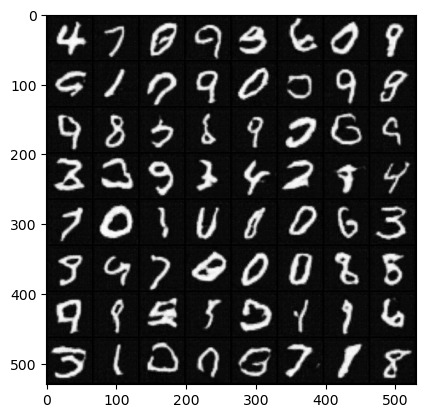

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from src.train import Generator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

params = {"nz": hps["nz"], "nc": 1, "ngf": hps["ngf"]}
model = load_model(
    "./tmp/model.pth", model_cls=Generator, params=params, device=device, strict=False
)
img = generate_fake_handwriting(model, num_images=64, nz=hps["nz"], device=device)

plt.imshow(np.asarray(img))
print("\nCan you guess which numbers are hand-written here?\n")

### Part-I ended
In this example, we dove deeper into the GAN technology and trained and tested a model. Let's see how the art of the possible can be achieve in part-II.

### Clean up

Run the following commandline in a terminal, to remove files generated by this notebook from S3 and local storage


In [36]:
import os

print(f"aws s3 rm --recursive s3://{bucket}/{prefix}")
print(f"rm -rf {os.path.abspath(dataroot)}")

aws s3 rm --recursive s3://sagemaker-us-east-1-578019895775/byos-pytorch-gan
rm -rf /root/cgan-workshop/Lab-1/data
